# EDA

In [43]:
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [1]:
import sys, os

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from windrose import WindroseAxes
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from utils import all_data, time_power_data
from preprocess import agg_data

import warnings

warnings.filterwarnings("ignore")

In [4]:
df = all_data()
df.shape

(50530, 5)

In [5]:
df.head()

,time,active_power,wind_speed,theoretical_power,wind_direction
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


- Date/Time (for 10 minutes intervals)
- LV ActivePower (kW): The power generated by the turbine for that moment
- Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
- TheoreticalPowerCurve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
- Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

In [5]:
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Time              50530 non-null  object 
 1   ActivePower(kW)   50530 non-null  float64
 2   WindSpeed(m/s)    50530 non-null  float64
 3   Power_Curve(KWh)  50530 non-null  float64
 4   Wind_Direction    50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [6]:
df.isnull().sum()

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

### Exploring values of power based on wind speed

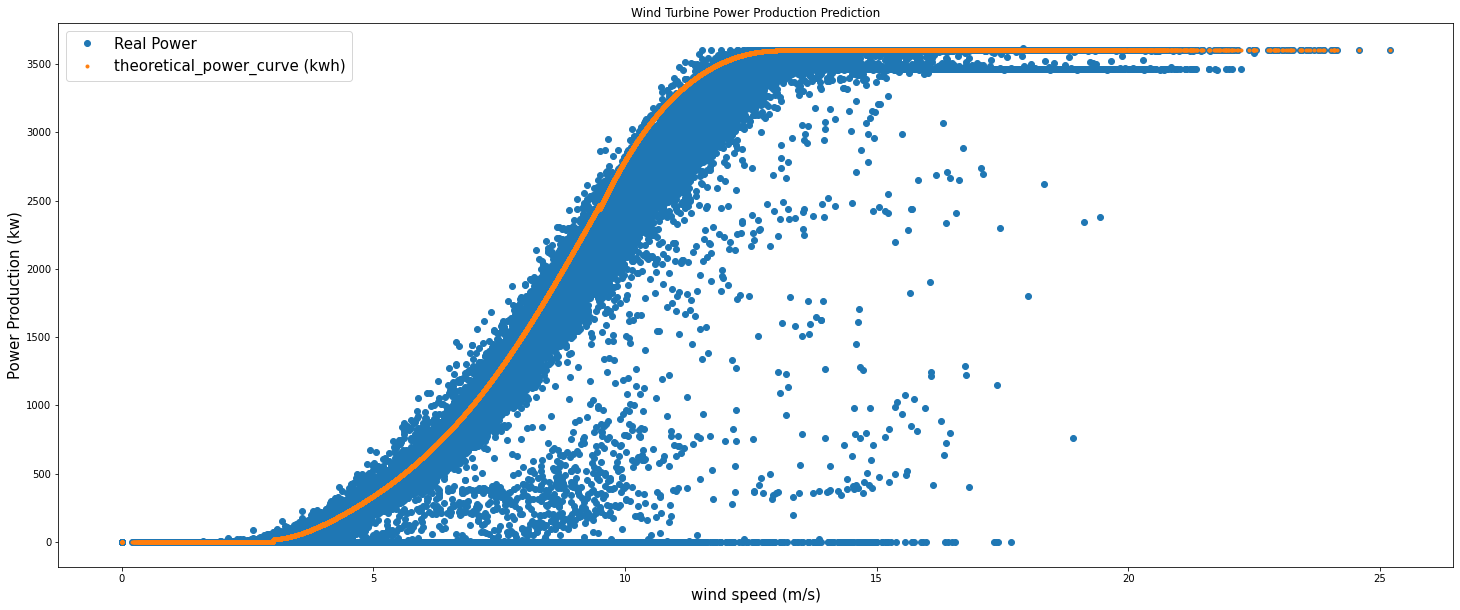

In [7]:
data = df
exp = data["active_power"]
the = data["theoretical_power"]
plt.figure(figsize=(25, 10))
plt.plot(data["wind_speed"], data["active_power"], "o", label="Real Power (kW)")
plt.plot(
    data["wind_speed"],
    data["theoretical_power"],
    ".",
    label="Theoretical Power Curve (kWh)",
)
plt.xlabel("wind_speed", size=15)
plt.ylabel("Power Production (kw)", size=15)
plt.title("Wind Turbine Power Production Prediction")
plt.legend(fontsize=15)
plt.show()

The power generated follows an S-curve, where it is at a minimum or maximum at a lower and upper threshold respectively. Wind speed beyond these thresholds will be filtered out for the model prediction. During inference these values can be hardcoded.

Real power generated falls within a close range of the theoretical power curve.

### Pair Plot

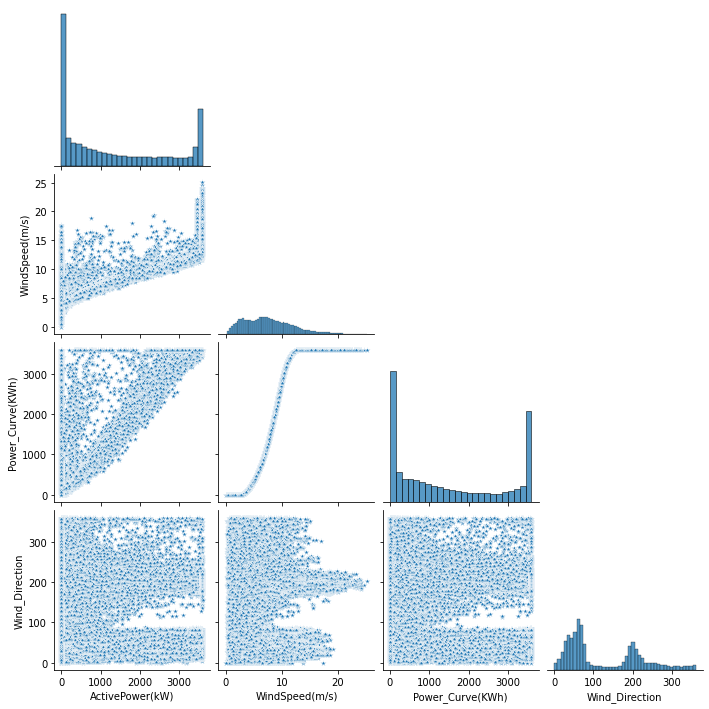

In [9]:
import seaborn as sns

sns.pairplot(df, markers="*", corner=True)

It is interesting to note that the theoretical power curve hits a limit despite high wind speeds. This might suggest a design restriction of the turbine. It seems that wind speed between 2.5 and 25 generate activepower.

### Direction Analysis

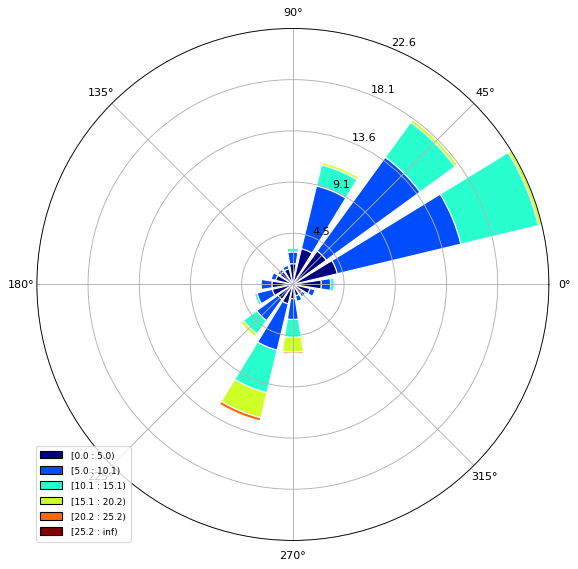

In [10]:
ax = WindroseAxes.from_ax()
ax.bar(
    df["wind_direction"], df["wind_speed"], normed=True, opening=0.8, edgecolor="white"
)
ax.set_legend()
plt.show()

There are two primary directions where wind is coming from. Wind Direction will be binned into 4 regions.

### Correlation Plot

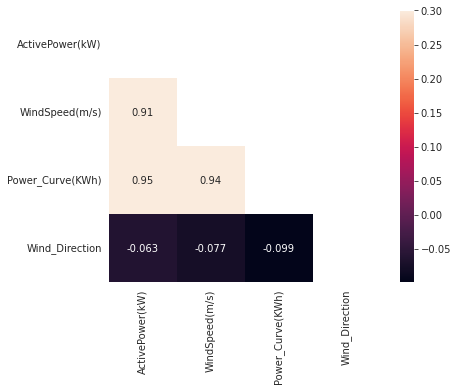

In [12]:
# correlation between the values
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=0.3, square=True, annot=True)

Wind speed has a high correlation with the power generated which is to be expected.

### Box Plot

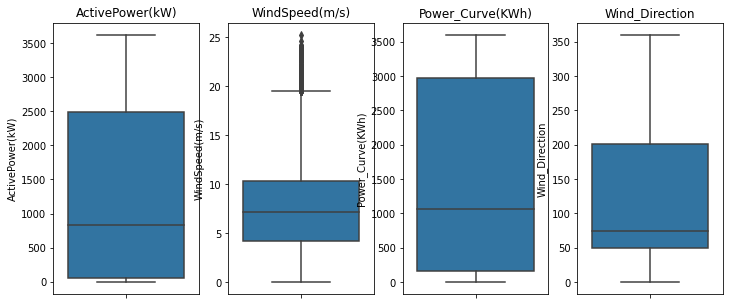

In [16]:
num_columns = df.select_dtypes("float").columns
i = 1
plt.figure(figsize=(12, 5))
for col in num_columns:
    plt.subplot(1, 4, i)
    sns.boxplot(data=df, y=col)
    plt.title(col)
    i += 1

Wind Speed between 20-25 m/s can be considered outliers. One potential way to handle this is to bin wind speeds and use the bins as a feature as it is an ordinal category.

### Seasonality Analysis

<AxesSubplot:xlabel='time'>

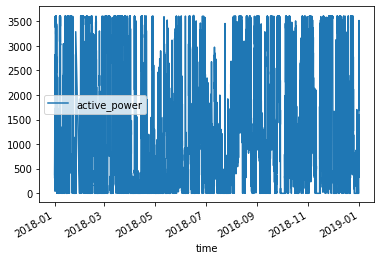

In [6]:
series = time_power_data(df)
series.plot()

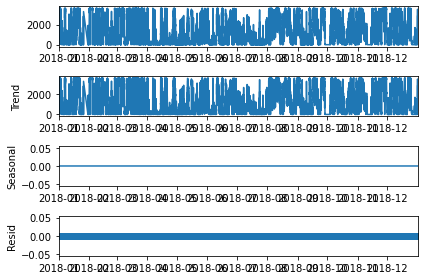

In [8]:
result = seasonal_decompose(series, model="additive", period=1)
result.plot()
plt.show()

We can see that the entire series was taken as the trend component and that there was no seasonality.  
As the residual plot shows zero, it shows that this decomposition was not able to separate the trend.

### Stationarity Test

- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (5%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#### Augmented Dickey-Fuller test

In [9]:
X = series.values
result = adfuller(X)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -14.008555
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


We can see that our p-value is less than the threshold of 0.05.

This suggests that we can reject the null hypothesis with a significance level of less than 5%. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

#### Autocorrelation Function

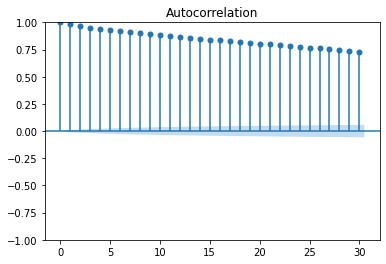

In [10]:
plot_acf(series.values, lags=30)
plt.show()

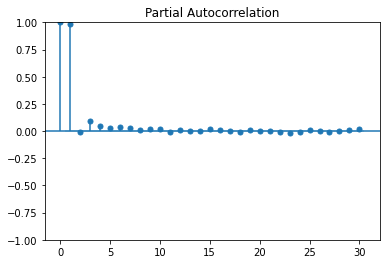

In [11]:
plot_pacf(series.values, lags=30)
plt.show()

The ACF shows a gradually decreasing trend while the PACF cuts immediately after two lags. Thus, the graphs suggest that an AR (2) model would be appropriate for the time series.

## Data Aggregation

#### Hour of day of year

In [45]:
df = all_data()
hour_agg = agg_data(df)
hour_agg.head()

,active_power
hour,
2018-01-01 00:00:00,390.480362
2018-01-01 01:00:00,460.537125
2018-01-01 02:00:00,733.655375
2018-01-01 03:00:00,909.362081
2018-01-01 04:00:00,1393.518188


<AxesSubplot:xlabel='hour'>

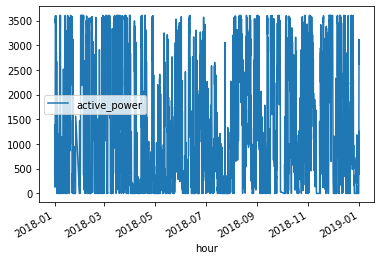

In [47]:
hour_agg.plot()

Hourly aggregations by day barely show a trend.

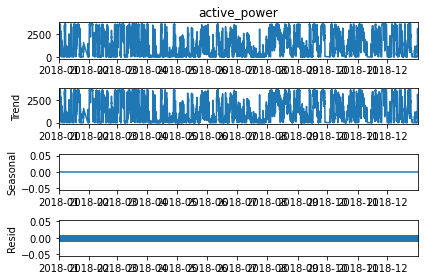

In [48]:
result_hour_decompose = seasonal_decompose(
    hour_agg["active_power"], model="additive", period=1
)
result_hour_decompose.plot()
plt.show()

The trend graph follows the plot of the column. The seasonality is at 0 as well as residuals. This suggests that this aggregation is not time dependent.

In [49]:
result_hour = adfuller(hour_agg["active_power"])
print("ADF Statistic: %f" % result_hour[0])
print("p-value: %f" % result_hour[1])
print("Critical Values:")
for key, value in result_hour[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -11.908651
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Performing an aggregation by the hour, the p-value is less than 0.05, thus outlining that the hourly aggregations are stationary and do not have a time dependent structure.

#### Day of year

In [50]:
day_agg = agg_data(df, time_frame="day")
day_agg.head()

,active_power
time,
1,1535.204483
2,3182.564250
3,1017.793340
4,834.486869
5,123.717345


<AxesSubplot:xlabel='time'>

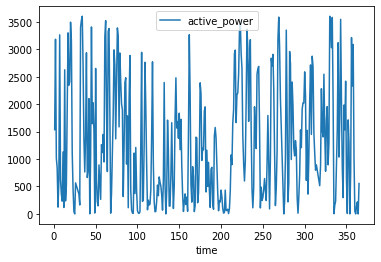

In [51]:
day_agg.plot()

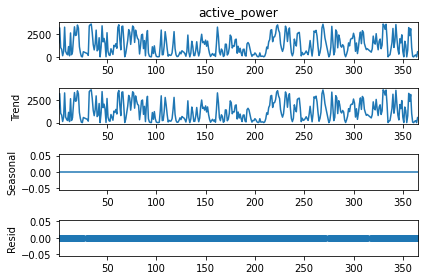

In [52]:
result_day_decompose = seasonal_decompose(
    day_agg["active_power"], model="additive", period=1
)
result_day_decompose.plot()
plt.show()

In [53]:
result_day = adfuller(day_agg["active_power"])
print("ADF Statistic: %f" % result_day[0])
print("p-value: %f" % result_day[1])
print("Critical Values:")
for key, value in result_day[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -8.209581
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


The result for the day of year aggregation follows the same result as the original data and the hour of day aggregation.

#### Month

In [54]:
month_agg = agg_data(df, time_frame="month")
month_agg.head()

,active_power
time,
1,1323.157951
2,1503.355020
3,1952.405766
4,824.358603
5,836.941996


<AxesSubplot:xlabel='time'>

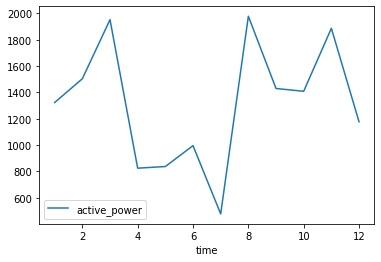

In [55]:
month_agg.plot()

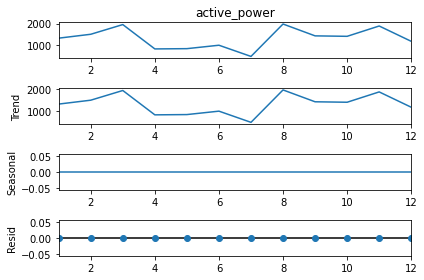

In [56]:
result_month_decompose = seasonal_decompose(
    month_agg["active_power"], model="additive", period=1
)
result_month_decompose.plot()
plt.show()

The trend graph of the monthly aggregation follows the plot of the original data. However the seasonality is at 0.

In [57]:
result_month = adfuller(month_agg["active_power"])
print("ADF Statistic: %f" % result_month[0])
print("p-value: %f" % result_month[1])
print("Critical Values:")
for key, value in result_month[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -2.665312
p-value: 0.080236
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803


From the results of the ADF test, it can be concluded that the monthly aggregation is not stationary as the null hypothesis is accepted. Thus it has a time depedence structure.

Grouping the data over a monthly period is not a sustainable measurement of wind power generation. Since the original data, hourly, and daily aggregations are stationary, a time series model can be trained on those levels of granularity. As wind speed varies with high volatility, and the ADF statistic varies, the daily aggregation dataset will be considered for an ARIMA model, this will be explored in the file `time-series.ipynb`.